In [90]:
#The basics
import pandas as pd
import numpy as np
import json

#Xg MODEL
from expectedGoal import xG

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Decide which league to load
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('wyscoutEvents/events_England.json') as f:
    data = json.load(f)
#data = pd.DataFrame(data)


In [2]:
#Create a data set of shots.
train = pd.DataFrame(data)
#only want the shots
cross=train[train['subEventId']==80]
#create empty data frame
#shots_model=pd.DataFrame(columns=['Goal','X','Y'])


In [25]:
len(train['matchId'].unique())

380

In [14]:
cross.columns

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')

In [17]:
cross['eventSec']

45          93.961235
75         228.764258
80         235.809436
86         251.068319
137        486.183517
             ...     
642828    1482.329472
642900    1809.230004
642989    2079.858095
643096    2642.981466
643143    2789.232666
Name: eventSec, Length: 12251, dtype: float64

In [4]:
cross['tags']

45        [{'id': 301}, {'id': 402}, {'id': 801}, {'id':...
75        [{'id': 1901}, {'id': 401}, {'id': 2101}, {'id...
80                              [{'id': 401}, {'id': 1801}]
86                 [{'id': 402}, {'id': 801}, {'id': 1802}]
137                             [{'id': 401}, {'id': 1802}]
                                ...                        
642828             [{'id': 401}, {'id': 801}, {'id': 1802}]
642900             [{'id': 302}, {'id': 402}, {'id': 1801}]
642989             [{'id': 402}, {'id': 801}, {'id': 1801}]
643096                          [{'id': 402}, {'id': 1802}]
643143            [{'id': 402}, {'id': 2101}, {'id': 1802}]
Name: tags, Length: 12251, dtype: object

In [5]:
pitchLengthX=120
pitchWidthY=80
startx =[]
starty= []
endx=[]
endy=[]
for i,cro in cross.iterrows():
    #print(cro['positions'][0])
    startx.append((cro['positions'][0]['x']/100)*pitchLengthX)
    starty.append((cro['positions'][0]['y']/100)*pitchWidthY)
    if (cro['positions'][1]['x'] ==100 and cro['positions'][1]['y'] ==100):
        continue
    elif(cro['positions'][1]['x'] ==0 and cro['positions'][1]['y'] ==0):
        continue
    else:
        endx.append((cro['positions'][1]['x']/100)*pitchLengthX)
        endy.append((cro['positions'][1]['y']/100)*pitchWidthY)
#make histogram of start crosses
H_Cross_start = np.histogram2d(starty, startx,bins=50,range=[[0, pitchWidthY],[0, pitchLengthX]])
H_Cross_end = np.histogram2d(endy, endx,bins=50,range=[[0, pitchWidthY],[0, pitchLengthX]])

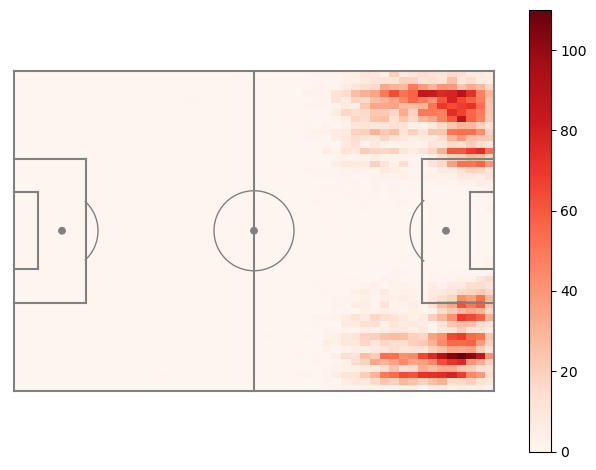

In [6]:
from FCPython import createPitch
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
pos=ax.imshow(H_Cross_start[0], extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
#ax.set_title('Danger passes per match by ' + team_required)
plt.xlim((-1,121))
plt.ylim((83,-3))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#fig.savefig('Output/HeatmapOfPasses' + team_required + '.pdf', dpi=None, bbox_inches="tight") 

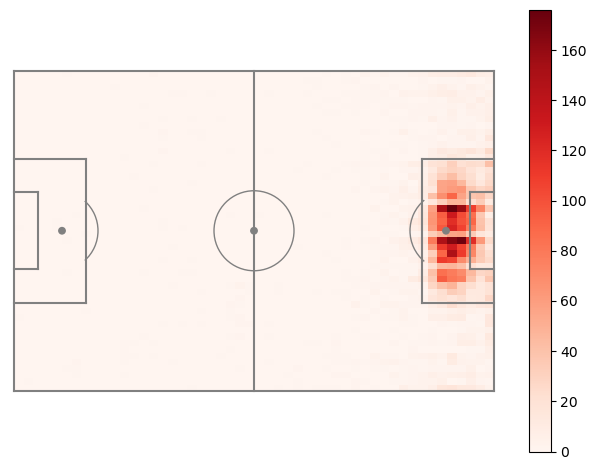

In [7]:
from FCPython import createPitch
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
pos=ax.imshow(H_Cross_end[0], extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
#ax.set_title('Danger passes per match by ' + team_required)
plt.xlim((-1,121))
plt.ylim((83,-3))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#fig.savefig('Output/HeatmapOfPasses' + team_required + '.pdf', dpi=None, bbox_inches="tight") 

In [9]:
def P2Gangle(x,y):
    #x distance from endline to point
    #y distance from point to centrline of pitch 
    a = 11
    b = np.sqrt((x-11)**2+y**2)
    c = np.sqrt(x**2 + y**2)
    theta = np.arccos((a**2-b**2-c**2)/(-2*b*c))
    return(np.degrees(theta))

In [10]:
x=27
y=21
a = 11
b = np.sqrt((x-11)**2+y**2)
c = np.sqrt(x**2 + y**2)
theta = np.arccos((a**2-b**2-c**2)/(-2*b*c))
P2Gangle(x,y)

14.821068070918363

In [26]:
cross['tags']

45        [{'id': 301}, {'id': 402}, {'id': 801}, {'id':...
75        [{'id': 1901}, {'id': 401}, {'id': 2101}, {'id...
80                              [{'id': 401}, {'id': 1801}]
86                 [{'id': 402}, {'id': 801}, {'id': 1802}]
137                             [{'id': 401}, {'id': 1802}]
                                ...                        
642828             [{'id': 401}, {'id': 801}, {'id': 1802}]
642900             [{'id': 302}, {'id': 402}, {'id': 1801}]
642989             [{'id': 402}, {'id': 801}, {'id': 1801}]
643096                          [{'id': 402}, {'id': 1802}]
643143            [{'id': 402}, {'id': 2101}, {'id': 1802}]
Name: tags, Length: 12251, dtype: object

In [105]:
#only gonna look at successful crosses now
#location of orignal cross
cross_model = pd.DataFrame(columns=['Successful','X','Y'])

for i,c in cross.iterrows():
    #match id
    cross_model.at[i,'matchId']=c['matchId']
    #time of event
    cross_model.at[i,'matchPeriod'] = c['matchPeriod']
    cross_model.at[i,'Sec']=c['eventSec']
    #distance from attacking goal endline
    cross_model.at[i,'X']=int(100-c['positions'][0]['x'])
    cross_model.at[i,'Y']=int(c['positions'][0]['y'])
    cross_model.at[i,'C']=abs(c['positions'][0]['y']-50)#distance from centre line
    
    #get xG of end location
    
    
    #distance from goal
    x=cross_model.at[i,'X']*105/100
    y=cross_model.at[i,'C']*65/100
        #Euciledean Distance
    cross_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
    
    #angle peno spot to 6 yard box
    cross_model.at[i,'Angle'] = P2Gangle(x,y)
    
    #corner?
    cross_model.at[i,'Corner']=0
    if c['eventId']==3:
        cross_model.at['Corner']=1
    #high or low
    cross_model.at[i,'Goal']=0
    cross_model.at[i,'Successful']=0
    cross_model.at[i,'high']=0
    cross_model.at[i,'inverted']=0
    cross_model.at[i,'xG']=0
    
    
    for tags in c['tags']:
        if tags['id'] == 1801:
            cross_model.at[i,'Successful']=1
            
            x=100-c['positions'][1]['x']#use .at to access single value, similar to .loc
        #y coordinate unchanged
            y=c['positions'][1]['y']#2 dictionary within a list, keys = 'x','y'
        #to get the distance shot to the center line
            c=abs(c['positions'][1]['y']-50)
    
        #Distance in metres and shot angle in radians.
        #x and y data are actually percentage of field.
        #in order to get actual meters divide by hundered to get fraction then mulitply by the dimensions
        #105by65
            x=x*105/100
            y=y*65/100
        #Euciledean Distance
            s=np.sqrt(x**2 + y**2)
        #angle
            a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        

            cross_model.at[i,'xG'] = xG(a=a,d=s)
            
        if tags['id'] == 301:
            cross_model.at[i,'Goal']=1
        
        if tags['id'] == 801:
            cross_model.at[i,'high']=1
        if tags['id'] == 802:
            cross_model.at[i,'high']=2
            #https://dataglossary.wyscout.com/pitch_coordinates/ needed to understand where is left and right flank
       # if ((c['positions'][0]['y']-50) < 0) and (tags['id'] == 402):
         #   cross_model.at[i,'inverted']=1
  #      if ((c['positions'][0]['y']-50) > 0) and (tags['id'] == 401):
   #         cross_model.at[i,'inverted']=1
            
            
        

In [112]:
cross_model['X'] = cross_model['X'].astype(float)
cross_model['Y'] = cross_model['Y'].astype(float)
cross_model.dtypes

Successful      object
X              float64
Y              float64
matchId        float64
matchPeriod     object
Sec            float64
C              float64
Distance       float64
Angle          float64
Corner         float64
Goal           float64
high           float64
inverted       float64
xG             float64
dtype: object

In [66]:
#build logistical model
#only ging to look at distance from goal first
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Successful ~ Distance" , data=cross_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                         Generalized Linear Model Regression Results                          
Dep. Variable:     ['Successful[0]', 'Successful[1]']   No. Observations:                12251
Model:                                            GLM   Df Residuals:                    12249
Model Family:                                Binomial   Df Model:                            1
Link Function:                                  Logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -7551.0
Date:                                Sun, 23 Oct 2022   Deviance:                       15102.
Time:                                        18:09:42   Pearson chi2:                 1.23e+04
No. Iterations:                                     5   Pseudo R-squ. (CS):          0.0007659
Covariance Type:                            nonrobust                                         
                 coef    std err          z      P

In [47]:
cross_model['Distance'].describe()

count    12251.000000
mean        27.873591
std          7.339593
min          4.669582
25%         23.036113
50%         28.272115
75%         32.919447
max         79.106337
Name: Distance, dtype: float64

In [71]:
#Show empirically how distance from goal predicts probability of successful cross
succcount_dist=np.histogram(cross_model.loc[cross_model['Successful']==1,'Distance'],bins=40,range=[4, 70])
count_dist=np.histogram(cross_model['Distance'],bins=40,range=[4, 70])
prob_succ=np.nan_to_num(np.divide(succcount_dist[0],count_dist[0]))
dis=count_dist[1]

/tmp/ipykernel_3987/360355090.py:4: RuntimeWarning: invalid value encountered in divide
  prob_succ=np.nan_to_num(np.divide(succcount_dist[0],count_dist[0]))


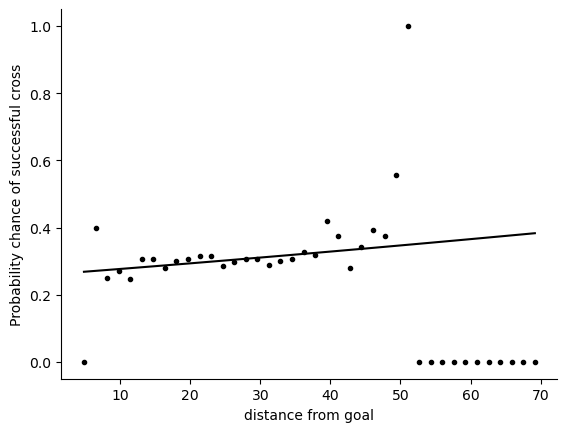

In [72]:
#ValueError: x and y must have same first dimension, but have shapes (41,) and (40,)
middis= (dis[:-1] + dis[1:])/2

#plotting the probabilty of successful using distance from goal
xCprob=1/(1+np.exp(b[0]+b[1]*middis)) 
fig,ax=plt.subplots(num=1)
ax.plot(middis, prob_succ, linestyle='none', marker= '.', color='black')
ax.plot(middis, xCprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance of successful cross')
ax.set_xlabel("distance from goal")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
#fig.savefig('Output/ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight")   




In [74]:
cross_model.columns

Index(['Successful', 'X', 'Y', 'matchId', 'matchPeriod', 'Sec', 'C',
       'Distance', 'Angle', 'Corner', 'Goal', 'height', 'inverted'],
      dtype='object')

In [98]:
cross_model.dtypes

Successful      object
X               object
Y               object
matchId        float64
matchPeriod     object
Sec            float64
C              float64
Distance       float64
Angle          float64
Corner         float64
Goal           float64
high           float64
inverted       float64
xG             float64
dtype: object

In [96]:
model_variables = ['X','C']#,'X','C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

In [113]:
#simple model only looking at distance and angle
#Fit the model

test_model = smf.glm(formula="Goal ~ " + model, data=cross_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                12251
Model:                            GLM   Df Residuals:                    12248
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -972.86
Date:                Sun, 23 Oct 2022   Deviance:                       1945.7
Time:                        19:25:12   Pearson chi2:                 1.21e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003210
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3523      0.276     -8.512      0.0

In [114]:
#Return xC value for more general model
#sh = row of the shots_model df
#%%capture
def calculate_xC(sh):
#sh = shots_model.iloc[1,:]
    bsum=b[0]
    for i,v in enumerate(model_variables):
        print(sh[v])
        bsum=bsum+b[i+1]*sh[v]
    xC = 1/(1+np.exp(bsum)) 
    return xC   
#xG
#Add an xG to my dataframe
#usiong apply function, only works if input to the function is a row




In [ ]:
#Create a 2D map of xC
#therefore getting the xC for every possible position on the pitch
#create a df with the fake xs, and ys and hence angles

pgoal_2d=np.zeros((65,65))

for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        
        sh['Angle'] = P2Gangle(x,y)
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        #sh['D2'] = x**2 + abs(y-65/2)**2
        #sh['X'] = x
        #sh['AX'] = x*a
        #sh['X2'] = x**2
        #sh['C'] = abs(y-65/2)
        #sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))